# 0: Section Overview

In the final section of our report, we will directly compare the performance of each model on a randomly selected country within the test data and visualize each model's predicted reproduction rate across the time period. We will also assess how each model performed on the entire test dataset, using our chosen performance metric, Mean Squared Error (MSE), to evaluate overall predictive performance. Finally, we will discuss the strengths and limitations of MSE as an evaluation metric and its implications for model reliability in similar predictive tasks.


# 1: Necessary Imports



In [28]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 2: Data access

As done previously, we need to access the test and training datasets.

In [5]:
test_filepath = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\Assessment_1\Train_and_Test_data\test.xlsx" # Enter your file path for the train data
train_filepath = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\Assessment_1\Train_and_Test_data\train.xlsx" # Enter your file path for the test data

test_data = pd.read_excel(test_filepath)
train_data = pd.read_excel(train_filepath)

# 3: Model Performance Comparison

As previously mentioned, this section of the conclusion will focus on comparing the performance of the models based on our performance metric, Mean Squared Error (MSE). We will evaluate MSE for a randomly selected country within the test dataset as well as for the entire dataset to provide a broader view of each model's accuracy. Additionally, we will perform visualization comparisons, plotting the reproduction rate for the selected country with each model’s predictions overlaid. This way, we can analyze both the quantitative result and how well each models' prediction aligns visually with the actual reproduction rate. Note, each group member has put forward their cross-validated, best model (i.e. the best implimentation of their model and not just the vanilla version).

### Random Test Country Comparison 

- graph
- MSE values
- comparing these results 
- what this means for our model
- talk about the graph and MSE for that country
- Generalising to the whole testing dataset talk about the MSE for the entire model

### Selecting a country 

The following block of code takes all the unique iso_codes from the test data and randomely selects one of them. This iso_code will determine which country from the test data we perform this model comparison on.

In [16]:
random.seed(21) # for replicability
iso_codes = test_data['iso_code'].unique()
random_iso_code = random.choice(iso_codes)
print(random_iso_code)

GBR


Now, we want to train our models in exactly the same way as before but instead of testing the models on the entire testing dataset, we can filter the test results to only include data from our randomely selected country. We also need to perform the standard selecting of covariate columns as we have done in the previous model implimentations

In [87]:
random_country_test_data = test_data[test_data['iso_code'] == random_iso_code]

#### Training data

In [75]:
covariates = ['Mean_Stringency_Index','CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index','days_since','total_cases','total_deaths','new_cases','new_deaths']
covariates_and_repr = covariates + ['reproduction_rate']
train_data_filtered = train_data[covariates_and_repr]
X_train = train_data_filtered[covariates]
y_train = train_data_filtered['reproduction_rate']
print()
print(X_train.shape)
print(len(y_train))


(134618, 9)
134618


#### Testing data

In [76]:
test_data_filtered = test_data[covariates_and_repr]
X_test = test_data_filtered[covariates]
y_test = test_data_filtered[['reproduction_rate']]
print()
print(X_test.shape)
print(len(y_test))



(32431, 9)
32431


#### Testing data for random country 

We want to access the test data just for the single country aswell.

In [79]:
random_country_X_test = random_country_test_data[covariates]
random_country_Y_test = random_country_test_data['reproduction_rate']



#### Retraining the models with cross-validated hyperparameters

In order to plot the Reproduction rate, we need to train and test each model as in each model section. we will also test each model on solely the GBR data aswell to see how each model performed in this particular country case.

#### Linear Model

In [132]:
linear_model = LinearRegression()
# Fit the model on the training data
linear_model.fit(X_train, y_train)
# Make predictions on the test data
y_pred_linear = linear_model.predict(X_test)
#print("y_pred shape:", y_pred_linear.shape)
# Calculate Mean Squared Error (MSE) on the test data
mse_linear = mean_squared_error(y_test, y_pred_linear)
R_squared_linear = linear_model.score(X_test, y_test)


y_pred_linear_random_country = linear_model.predict(random_country_X_test)
mse_linear_random_country = mean_squared_error(random_country_Y_test, y_pred_linear_random_country)
# R_squared_linear_random_country = linear_model.score(random_country_X_test, random_country_Y_test)

print(mse_linear)

0.13260849618243836


#### KNN model

Lucy performed multiple implimentations of the KNN model. She also created an enemble method with XGboost in an attempt to improve model performance. Furthermore, it is important to note that in the KNN section, Lucy implimented a scaling function on her test and training covariate data which worked to marginally improve her results. Given we want to fairly compare model performance, we will not perform any scaling on our datasets to ensure all test and training data is identical for each model.

##### KNN model

In [160]:
knn = KNeighborsRegressor(n_neighbors=100, p=1, weights='distance') 
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)

y_pred_knn_random_country = knn.predict(random_country_X_test)
mse_knn_random_country = mean_squared_error(random_country_Y_test, y_pred_knn_random_country)

##### Ensemble model

In [161]:
knn = KNeighborsRegressor(n_neighbors=15, p=1, weights='distance')
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=5)
ensemble_model = VotingRegressor(estimators=[('knn', knn), ('xgb', xgb_model)])
ensemble_model.fit(X_train, y_train)
y_pred_em = ensemble_model.predict(X_test)
mse_em = mean_squared_error(y_test, y_pred_em)

y_pred_em_random_country = ensemble_model.predict(random_country_X_test)
mse_em_random_country = mean_squared_error(random_country_Y_test, y_pred_em_random_country)


#### RF model

Similarly, Harry performed multiple implimentations of the RF model. The model initialised below was his final model submission adjusted through cross-validation. Since Harry implimented his section in R, in order to overlay the rf model result onto the graph, we reimplimented the RF model in python. 

In [168]:
rf_model_tuned = RandomForestRegressor(
    n_estimators=350,      # Number of trees
    max_features=2,        # Number of features to consider at each split (equivalent to mtry in R)
    bootstrap=True,        # Sample with replacement
    n_jobs=3,              # Number of parallel jobs to run (-1 to use all processors)
    random_state=42
)

# Fit the model
rf_model_tuned.fit(X_train, y_train)
y_pred_rf = rf_model_tuned.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
R_squared_rf = rf_model_tuned.score(X_test, y_test)
print(mse_rf)

y_pred_rf_random_country = rf_model_tuned.predict(random_country_X_test)
mse_rf_random_country = mean_squared_error(random_country_Y_test, y_pred_rf_random_country)



0.1142639881372257


##### Stacked model

### Visualising the reproduction rate w/ model predictions

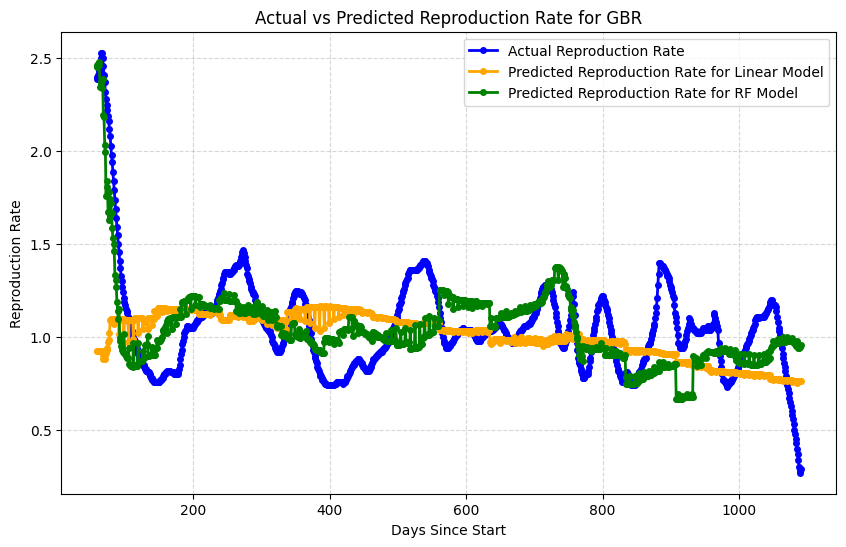

In [170]:
plt.figure(figsize=(10, 6))

# Plot actual and predicted values with different line styles and marker sizes
plt.plot(random_country_test_data['days_since'], random_country_test_data['reproduction_rate'], 
         label="Actual Reproduction Rate", color='blue', marker='o', markersize=4, linewidth=2)
plt.plot(random_country_test_data['days_since'], y_pred_linear_random_country, 
         label="Predicted Reproduction Rate for Linear Model", color='orange', marker='o', markersize=4, linewidth=2)
plt.plot(random_country_test_data['days_since'], y_pred_rf_random_country, 
         label="Predicted Reproduction Rate for RF Model", color='green', marker='o', markersize=4, linewidth=2)

# Add labels and title
plt.title(f"Actual vs Predicted Reproduction Rate for {random_iso_code}")
plt.xlabel("Days Since Start")
plt.ylabel("Reproduction Rate")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

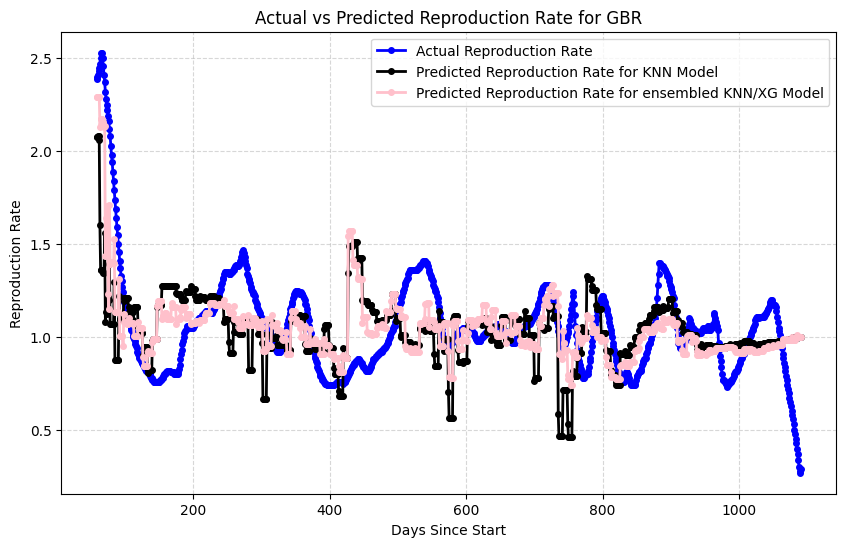

In [171]:
plt.figure(figsize=(10, 6))

# Plot actual and predicted values with different line styles and marker sizes
plt.plot(random_country_test_data['days_since'], random_country_test_data['reproduction_rate'], 
         label="Actual Reproduction Rate", color='blue', marker='o', markersize=4, linewidth=2)
plt.plot(random_country_test_data['days_since'], y_pred_knn_random_country, 
         label="Predicted Reproduction Rate for KNN Model", color='black', marker='o', markersize=4, linewidth=2)
plt.plot(random_country_test_data['days_since'], y_pred_em_random_country, 
         label="Predicted Reproduction Rate for ensembled KNN/XG Model", color='pink', marker='o', markersize=4, linewidth=2)

# Add labels and title
plt.title(f"Actual vs Predicted Reproduction Rate for {random_iso_code}")
plt.xlabel("Days Since Start")
plt.ylabel("Reproduction Rate")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [169]:
# Print a header
print('QUANTITATIVE RESULTS\n')
print(f'{"Model":<25} {"Metric":<45} {"Value":<10}')
print('-' * 80)

# Linear Model Results
print(f'{"Linear Model":<25} {"MSE using ALL test data":<45} {mse_linear:.4f}')
print(f'{"Linear Model":<25} {"MSE using only GBR test data":<45} {mse_linear_random_country:.4f}')
print()

# Random Forest Model Results
print(f'{"Random Forest Model":<25} {"MSE using ALL test data":<45} {mse_rf:.4f}')
print(f'{"Random Forest Model":<25} {"MSE using only GBR test data":<45} {mse_rf_random_country:.4f}')
print()

# knn Model Results
print(f'{"KNN Model":<25} {"MSE using ALL test data":<45} {mse_knn:.4f}')
print(f'{"KNN Model":<25} {"MSE using only GBR test data":<45} {mse_knn_random_country:.4f}')
print()

print(f'{"ensembled knn/XG Model":<25} {"MSE using ALL test data":<45} {mse_em:.4f}')
print(f'{"ensembled knn/XG Model":<25} {"MSE using only GBR test data":<45} {mse_em_random_country:.4f}')
print()





QUANTITATIVE RESULTS

Model                     Metric                                        Value     
--------------------------------------------------------------------------------
Linear Model              MSE using ALL test data                       0.1326
Linear Model              MSE using only GBR test data                  0.0917

Random Forest Model       MSE using ALL test data                       0.1143
Random Forest Model       MSE using only GBR test data                  0.0473

KNN Model                 MSE using ALL test data                       0.1735
KNN Model                 MSE using only GBR test data                  0.0822

ensembled knn/XG Model    MSE using ALL test data                       0.1362
ensembled knn/XG Model    MSE using only GBR test data                  0.0486



On a quantative level, we see that the model with the highest level of performance and therefore the lowest Mean Squared Error (MSE) value is the random Forest model. We see from the table that the lowest performing model on the standard test data was the KNN model which performed worse than the baseline model although ensembling technques worked to negate this slightly and improve performace (albeit not substantially enough so to provide better performance than the baseline). We also saw that the stacked model ... [INSERT]

By nature the MSE is 



say something about the linear models just stagnant straightness against the rf models attempt to follow the trends similar to that in the real reproduction rate but often overshooting 

Additionally something to be said about the variation in the MSE in each model. (improved performance for GBR)

# 4: Performance Metric Evaluation

the nature of our problem (one figure vs ROC curve for example)

why MSE might not be the best, why something ASE might be better, anything else

# 5: Limitation acknowledgements and Final Takeaways

- any kind of things you would have added to your models if you had more time (breif). 




Ultimately, the best performing model in our report was the __. We see that the MSE was lower than the other model implimentation in both the case when we solely considered one country (as we may do in our real world scenario of attempting to predict North Korea's reproduction rate over this period) and when we tested the models on a larger subset of the entire dataset. The plot of the predicted reproduction rates mirrored this result as we saw the __ model was following similar downward and upward trends at certain times to the real reproduction rate of GBR. Ultimately whilst the aim of this project was to compare model performance in the context of mapping the reproduction rate of the covid-19 virus and not solely to create the best performing model possible, none of these models performed particulalry well (as outlined in the baseline model section, under 'Assessing these results') or signficiantly outperformed the others and their application in a real world environment should be taken with caution. 



Ultimately, the best-performing model in our analysis was the __. This model demonstrated a lower Mean Squared Error (MSE) compared to the other implementations, both when focused on a single country—such as in our real-world scenario of predicting North Korea's reproduction rate—and when evaluated on a larger subset of the entire dataset. The plot of the predicted reproduction rates corroborated these findings, as the __ model closely mirrored the upward and downward trends of the actual reproduction rate observed in Great Britain (GBR) at various times. While the primary objective of this project was to compare the performance of different models in mapping the COVID-19 reproduction rate, rather than solely to identify the best-performing model, it is important to note that none of these models performed exceptionally well. As discussed in the baseline model section under 'Assessing these results,' caution should be exercised when applying these models in real-world situations.